# Agent with Basic Functionality and Configuration

## References 

https://www.youtube.com/watch?v=hvAPnpSfSGo


## States

In [1]:
import operator
from dataclasses import dataclass
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

from pydantic import BaseModel, Field


# TODO: separate input and output schemas
@dataclass
class InputPlanningState(TypedDict):
    pass


@dataclass
class PlanningState(TypedDict):
    """State of conversation between Agent and User."""

    project_description: Annotated[
        str, "Description of the project"
    ]  # Initial idea/explaination of the project
    messages: Annotated[
        list[str], add_messages
    ]  # Clarifying questions to refine the project idea

    project_plan: Annotated[list[str], operator.add]  # generated by Agent/s


class SearchQuery(BaseModel):
    """Agent will use this to search for information."""

    query: str = Field(..., description="The query to search for")


## Strategy Pattern for Model Providers

In [2]:
from abc import ABC, abstractmethod
from typing import Any

from langchain_core.language_models.chat_models import BaseChatModel
from langchain_openai import ChatOpenAI


class LLMProvider(ABC):
    """Abstract base class for LLM providers."""

    def __init__(self) -> None:
        """Initialize the LLM provider."""
        self.llm = None

    @abstractmethod
    def _create_llm_instance(self) -> BaseChatModel:
        """Abstract method to create LLM instance.

        This must be implemented by subclasses/Providers.
        """
        raise NotImplementedError

    def __getattr__(self, name: str) -> Any:
        """Delegate attribute access to the underlying LLM instance.

        This is the magic that allows us to call methods like `invoke`,
        `stream`, etc., directly on an `LLMProvider` instance, and they
        will be forwarded to the actual `self.llm` object (e.g., ChatOpenAI).
        """
        if self.llm is None:
            raise AttributeError(
                f"'{self.__class__.__name__}' has no LLM instance. The LLM client may not be initialized yet."
            )
        return getattr(self.llm, name)


class OpenAIProvider(LLMProvider):
    """Concrete LLM provider for OpenAI models."""

    def __init__(
        self, model_name: str = "gpt-4o", temperature: float = 0.0, **kwargs
    ) -> ChatOpenAI:
        """Initialize the OpenAIProvider."""
        self.model_name = model_name
        self.temperature = temperature
        self.kwargs = kwargs
        self.llm = self._create_llm_instance()

    def _create_llm_instance(self) -> BaseChatModel:
        """Concrete LLM provider for OpenAI models."""
        try:
            return ChatOpenAI(
                model=self.model_name, temperature=self.temperature, **self.kwargs
            )
        except Exception as e:
            raise RuntimeError(f"Failed to create ChatOpenAI instance: {e}")


## Create a Web Search Tool

In [ ]:
INIT_SYSTEM_PROMPT = """ Project Description:
{project_description}

1. your Persona and Prime Directive
You are an expert AI Software Architect and Project Planner. Your primary goal is to take a user's project idea and transform it into a comprehensive, actionable, and well-structured project blueprint. You must act as a technical co-founder, thinking critically about the project's feasibility, architecture, and phased rollout. Your final output must be a detailed Markdown document suitable for direct use in project management tools like GitHub Projects. Keeping mind that You are instructing a solo SW Engineer to create a project plan.
2. Your Tasks:
    * Step-by-Step Project Plan: Generate a detailed, stepwise plan for the project, starting from the MVP (Minimum Viable Product) to advanced feature implementations.
    * Feature Progression: Clearly outline which features are part of the MVP and how to incrementally add advanced features, with justification for the order of implementation.
    * Design Patterns: Recommend specific design patterns for each major component or step, explaining why each is suitable and how to implement it in the context of the project.
    * Project Structure: Suggest a logical and scalable project folder/file structure, following best practices for the chosen tech stack.
    * Best Practices: List the best practices relevant to the project, including coding standards, testing, documentation, CI/CD, and collaboration tips.
    * Frameworks & Technologies: Recommend the most suitable frameworks, libraries, and technologies for the project, with reasons for each choice.
    * Markdown Output: Present the entire project plan in well-formatted Markdown, using headings, subheadings, bullet points, and tables where appropriate. The output should be directly usable for creating GitHub issues and Kanban board tasks.
    * Clarification Questions: Before finalizing the plan, ask me any clarification questions needed to tailor the plan to my goals, preferences, or constraints (e.g., target platform, team size, deadlines, prior experience, deployment requirements, etc.).
    * Tool Usage: You may use external tools and sources (e.g., Python, Wikipedia, TavilySearch) to gather information and improve your recommendations.

 """


In [4]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph.errors import NodeInterrupt

# Search query writing
SEARCH_INSTRUCTIONS = SystemMessage(
    content="""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query"""
)


tavily_search = TavilySearch(max_results=3)


@tool
def search_web(state: PlanningState) -> PlanningState:
    """Retrieve information from the web."""
    structured_llm = llm.with_structured_output(SearchQuery)
    project_description = state.project_description
    search_query: SearchQuery = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS.format(project_idea=project_description)]
        + state["messages"]
    )
    search_docs = tavily_search.invoke(search_query.query)
    # format
    formatted_search_docs = [
        f"""<Document href='{doc["url"]}'messages/>\n{doc["content"]}\n<Document>"""
        for doc in search_docs
    ]

    return {"project_plan": [formatted_search_docs]}


@tool
def search_wikipedia(state: PlanningState) -> PlanningState:
    """Retrieve information from Wikipedia."""
    structured_llm = llm.with_structured_output(SearchQuery)

    project_description = state.project_description

    search_query: SearchQuery = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS.format(project_description=project_description)]
        + state["messages"]
    )
    search_docs = tavily_search.invoke(search_query.query)
    # format
    formatted_search_docs = [
        f"""<Document href='{doc["url"]}'/>\n{doc["content"]}\n<Document>"""
        for doc in search_docs
    ]

    state.project_plan = [formatted_search_docs]
    return {"project_plan": [formatted_search_docs]}


#  TODO: add Python tool

TOOLS = [search_wikipedia]  # search_wikipedia]

In [5]:
# search_web.invoke(PlanningState(project_description="I want to build a chatbot"))

In [6]:
# TODO: add router function to route between tools and llm or end

## Configuration


In [ ]:
from langgraph.checkpoint.memory import MemorySaver

thread = {"configuration": {"thread_id": "1"}}

## Graph


In [ ]:
llm = OpenAIProvider()

SYSTEM_PROMPT_PROJECT_PLAN_STRUCTURE = """ here is the reseached information about the project plan details: {project_plan}
     you can submit the final project plan details in markdown format as shown below. 
     Mandatory Output Format (The Project Blueprint)
    Your final output must adhere strictly to the following Markdown structure. Use headings, lists, tables, and code blocks exactly as specified.
    # Project Blueprint: [Project Name]

    ## 1. Executive Summary
    A brief, high-level overview of the project and the proposed technical approach. Summarize the core problem and the solution.

    ## 2. Technology Stack Recommendation
    Provide a table of recommended technologies and a detailed justification for each choice.

    | Category          | Technology / Framework | Justification                                                                                             |
    |-------------------|------------------------|-----------------------------------------------------------------------------------------------------------|
    | **Frontend** | e.g., React, Next.js   | e.g., Rich ecosystem, component-based architecture suits modularity, strong community support.            |
    | **Backend** | e.g., Node.js, Express | e.g., Non-blocking I/O is ideal for real-time features, JavaScript consistency across the stack.        |
    | **Database** | e.g., PostgreSQL       | e.g., Strong support for relational data, JSONB for flexibility, and proven scalability.                  |
    | **Deployment** | e.g., Docker, Vercel   | e.g., Vercel simplifies frontend deployment; Docker ensures consistent environments for the backend.        |
    | **Authentication**| e.g., Auth0, NextAuth  | e.g., Reduces development time and security risks by handling complex authentication flows.               |

    ## 3. Project Structure & Architectural Patterns
    Provide a recommended folder structure and explain the key design patterns to be used.

    ### Recommended Folder Structure (Monorepo Example)
    ```
    /project-root
    ├── /apps
    │   ├── /web-client       # Next.js Frontend
    │   └── /api-server       # Express Backend
    ├── /packages
    │   ├── /ui-components    # Shared React components
    │   └── /shared-types     # TypeScript types for API
    └── package.json
    ```

    ### Key Design Patterns
    | Pattern Name                | Where to Apply                               | Rationale                                                                        |
    |-----------------------------|----------------------------------------------|----------------------------------------------------------------------------------|
    | **Model-View-Controller (MVC)** | Backend API structure                        | Separates concerns, making the application easier to maintain and scale.         |
    | **Repository Pattern** | Data access layer in the backend             | Decouples business logic from data sources, allowing for easier testing and swapping of ORMs/DBs. |
    | **Component-Based Architecture** | Frontend UI development                   | Promotes reusability, modularity, and easier state management.                   |


    ## 4. Phased Development Plan (MVP to Full Launch)
    Break down the project into logical, sequential phases. Each feature should be a checklist item, perfect for creating GitHub issues.

    ### **Phase 1: Minimum Viable Product (MVP)**
    *The core functionality needed to solve the user's primary problem and gather initial feedback.*
    - [ ] **Feature:** User Authentication (Sign up, Login, Logout)
    - [ ] **Feature:** Core Data Model & Database Schema
    - [ ] **Feature:** Basic Dashboard for viewing data
    - [ ] **Chore:** Setup CI/CD pipeline for automated testing and deployment

    ### **Phase 2: Core Features (V1.0)**
    *Building on the MVP to create a more complete and useful product.*
    - [ ] **Feature:** [Advanced Feature A - e.g., Real-time collaboration]
    - [ ] **Feature:** [Advanced Feature B - e.g., User Profile Management]
    - [ ] **Feature:** [Advanced Feature C - e.g., Admin Panel]
    - [ ] **Chore:** Implement comprehensive logging and monitoring

    ### **Phase 3: Advanced Features (V1.1+)**
    *Features that enhance the product, add value, and respond to user feedback.*
    - [ ] **Feature:** [Nice-to-have Feature D - e.g., Third-party integrations]
    - [ ] **Feature:** [Nice-to-have Feature E - e.g., In-app notifications]

    ## 5. Key Best Practices
    Provide a final list of critical best practices to follow throughout the project lifecycle.
    - **Version Control:** Use Git with a clear branching strategy (e.g., GitFlow).
    - **Testing:** Write unit tests for business logic, integration tests for API endpoints, and end-to-end tests for critical user flows.
    - **Code Quality:** Use linters (ESLint, Prettier) and establish a coding style guide.
    - **Security:** Implement security headers, validate all user input, and protect against common vulnerabilities (OWASP Top 10).
    - **Documentation:** Maintain clear documentation for APIs and complex code sections.
"""


def call_agent_model(state: PlanningState) -> dict[str, Any]:
    """Call the primary Language Model (LLM) to decide on the next research action.

    This asynchronous function performs the following steps:
    1. Initializes configuration and sets up the 'Info' tool, which is the user-defined extraction schema.
    2. Prepares the prompt and message history for the LLM.
    3. Initializes and configures the LLM with available tools.
    4. Invokes the LLM and processes its response.
    5. Handles the LLM's decision to either continue research or submit final info.
    """
    # Load configuration

    # Define

    project_description = state["project_description"][0].content
    # Prepare prompt and message history
    prompt = INIT_SYSTEM_PROMPT.format(project_description=project_description)
    # print(prompt)
    message_history = [SystemMessage(content=prompt)] + state["messages"]

    # Initialize and configure LLM with available tools
    llm_with_tools = llm.bind_tools(TOOLS)

    # Invoke LLM and process response
    response = llm_with_tools.invoke(message_history)
    return {"messages": response}


def genereate_plan(state: PlanningState):
    """Generate markdown formate report depending on the conversion."""
    messages = state["messages"]
    project_plan = state.get("project_plan", "")

    system_message = SYSTEM_PROMPT_PROJECT_PLAN_STRUCTURE.format(
        project_plan=project_plan
    )
    messages = [SystemMessage(content=system_message)] + messages

    result = llm.invoke(messages)
    return {"project_plan": [result]}


def ask_user(state: PlanningState):
    """LLM asks human for input or clearification about the project plan."""
    agent_message = state["messages"][-1]
    if agent_message.endswith("?"):
        # Agent as a question for human
        raise NodeInterrupt("Agnet has question for user")
    return state


def should_continue(state: PlanningState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    else:
        return "generate_plan"

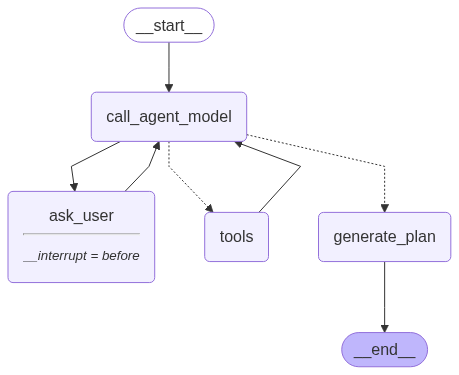

In [ ]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(PlanningState)  # , config_schema=Configuration)

# Nodes
builder.add_node("call_agent_model", call_agent_model)
builder.add_node("ask_user", ask_user)
builder.add_node("tools", ToolNode(TOOLS))
builder.add_node("generate_plan", genereate_plan)

# Edges
builder.add_edge(START, "call_agent_model")
builder.add_edge("call_agent_model", "ask_user")
builder.add_edge("ask_user", "call_agent_model")

builder.add_conditional_edges(
    "call_agent_model",
    should_continue,
    ["tools", "generate_plan"],
)
builder.add_edge("tools", "call_agent_model")
# builder.add_edge("call_agent_model", "generate_plan")
builder.add_edge("generate_plan", END)


graph = builder.compile(
    checkpointer=MemorySaver(),
    name="Planning Agent",
)
graph

In [ ]:
project_idea = "create plan to develop agentic AI note taking app using langgraph. it should take pictures of hand-written notes and it will automatically format the texts (it might contains equations and block diagrams) and find proper section in my notion and add this notes with proper format"

In [ ]:
messages = [HumanMessage(content=project_idea)]
messages = graph.invoke({"project_description": messages}, config=thread)


In [ ]:
messages["project_plan"][0].content


In [ ]:
# TODO: need breakpoint when Agent Ask question to user